In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
from tqdm import tqdm, trange, tqdm_notebook
import re
import nltk
from multiprocessing import cpu_count, Pool
from functools import partial
import ipywidgets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from rewrite.scorer import score_4class
import utils # utils from CS224U
from scipy.spatial import distance
import random
tqdm.pandas()
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment import vader

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gui/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/home/gui/anaconda3/envs/nlu4/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
def del_str_cols(df): # df should be X, e.g. X_train or X_dev
    to_del_names = ["articleBody", "Headline", "Body ID"]
    for name in to_del_names:
        if name in df.columns:
            del df[name]
    for col_name in df.columns:
        if "___" == col_name[0:3]:
            del df[col_name]
            
def print_reports(preds, actual):
    print(classification_report(actual, preds))
    score, max_score = score_4class(actual, preds)
    print("Weighted accuracy: "+str(score/max_score)+" ("+str(score)+" out of "+str(max_score)+")")

def print_feature_importances(model, df):
    feat_imp = model.feature_importances_
    indices = np.argsort(feat_imp)[::-1]
    for ii in indices:
        print(df.columns[ii]+": "+str(feat_imp[ii]))
        
# Usage: pass Xy_train (or a df with Body ID col., and y col. as well)
# returns the same format of df, but spplit so that no body ID is shared between sets
proportion_for_holdout_dev_set = 0.2
def disjoint_train_test_split(Xy, frac_for_test_set=proportion_for_holdout_dev_set, random_state=42):
    r = random.Random()
    r.seed(random_state)
    Xy_IDs = list(set(Xy["Body ID"]))
    print("Total unique IDs: "+str(len(Xy_IDs)))
    r.shuffle(Xy_IDs)
    num_IDs_for_train = int((1-frac_for_test_set)*len(Xy_IDs))
    train_IDs = Xy_IDs[:num_IDs_for_train]
    test_IDs = Xy_IDs[num_IDs_for_train:]
    train_df = Xy[Xy["Body ID"].isin(train_IDs)]
    test_df = Xy[Xy["Body ID"].isin(test_IDs)]
    print("# instances in train: "+str(train_df.shape[0]))
    print("# instances in test: "+str(test_df.shape[0]))
    assert len(set(train_df["Body ID"].unique()) & set(test_df["Body ID"].unique())) == 0 # totally disjoint
    return train_df, test_df

In [3]:
from multiprocessing import cpu_count, Pool
cores = cpu_count() 
partitions = cores
def parallelize(data, func):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

In [4]:
##### ADD OUR FEATURES
# START SENTIMENT ANALYSIS
def vader_pol_helper(df):
    return df.apply(lambda hl: pd.Series(sid.polarity_scores(hl)))
sid = vader.SentimentIntensityAnalyzer() # global scope for parallelization
def add_vader_sent(X_df):
    def vader_polarity_scores(df, text_col_name, col_name_prefix):
        pol_scores = parallelize(df[text_col_name], vader_pol_helper)
        #pol_scores = df[text_col_name].progress_apply(lambda hl: pd.Series(sid.polarity_scores(hl)))
        cols = pol_scores.columns
        new_cols = []
        for col_name in cols:
            new_cols.append("vader_"+col_name_prefix+"_"+col_name)
        pol_scores.columns = new_cols
        return pol_scores

    vader_hl_df = vader_polarity_scores(X_df, "Headline", "hl")
    vader_body_df = vader_polarity_scores(X_df, "articleBody", "body")
    X_df = pd.concat([X_df, vader_hl_df, vader_body_df], axis=1)
    return X_df

# END SENTIMENT ANALYSIS
### GLOVE ####
glove_dim = 200
glove_src = os.path.join("GloVe", 'glove.6B.'+str(glove_dim)+'d.txt')
GLOVE = utils.glove2dict(glove_src)
def text_to_mean_vec_ignore_unk(text, w2v=GLOVE, dim=glove_dim):
    vec = np.zeros(dim)
    num_added = 0
    for word in text:
        if word in w2v:
            vec += w2v[word]
            num_added += 1
    if num_added > 0:
        return vec/num_added
    else:
        return np.array([random.uniform(-0.5, 0.5) for i in range(glove_dim)])
def get_glove_cos_dist_hl_body(row):
    hl = row["___clean_headline_tokenized_lemmas"]
    body = row["___clean_body_tokenized_lemmas"]
    hl_vec = text_to_mean_vec_ignore_unk(hl)
    body_vec = text_to_mean_vec_ignore_unk(body)
    cosine_dist = distance.cosine(hl_vec, body_vec) # cosine() from scipy
    return cosine_dist

def get_verbs(text):
    verbs = [token for token, pos in nltk.pos_tag(text) if pos.startswith('VB')]
    verbs_sentence = ' '.join(word[0] for word in verbs)
    return verbs_sentence
 
def get_verb_glove_cos_dist_hl_body(row):
    hl = row["___clean_headline_tokenized_lemmas"]
    body = row["___clean_body_tokenized_lemmas"]
    
    hl_verbs = get_verbs(hl)
    body_verbs = get_verbs(body)
    
    hl_vec = text_to_mean_vec_ignore_unk(hl_verbs)
    body_vec = text_to_mean_vec_ignore_unk(body_verbs)
    cosine_dist = distance.cosine(hl_vec, body_vec) # cosine() from scipy
    return cosine_dist

def hl_body_glove_cos_dist_helper(X_df):
    return X_df[["___clean_headline_tokenized_lemmas", "___clean_body_tokenized_lemmas"]].apply(get_glove_cos_dist_hl_body, axis=1)

def hl_body_glove_verb_helper(X_df):
    return X_df[["___clean_headline_tokenized_lemmas", "___clean_body_tokenized_lemmas"]].apply(get_verb_glove_cos_dist_hl_body, axis=1)

### END GLOVE CODE BLOCK
def add_all_features(X_df, parallel=True):
    print("Adding glove feature #1...", flush=True)
    X_df["hl_body_glove_"+str(glove_dim)+"_cos_dist"] = parallelize(X_df, hl_body_glove_cos_dist_helper)
    print("Adding glove feature #2...", flush=True)
    X_df["hl_body_verb_glove_"+str(glove_dim)+"_cos_dist"] = parallelize(X_df, hl_body_glove_verb_helper)
    print("Adding VADER sentiment...", flush=True)
    X_df = add_vader_sent(X_df)
    return X_df

In [5]:
# Row 1: baseline (original features)
X_train = pd.read_hdf("X_train_disjoint-allfeatures.h5", key="df")
X_dev = pd.read_hdf("X_dev_disjoint-allfeatures.h5", key="df")
X_test = pd.read_hdf("X_TEST-allfeatures.h5", key="df")

y_train = pd.read_hdf("y_train_disjoint.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")


del_str_cols(X_train)
del_str_cols(X_dev)
del_str_cols(X_test)

y_train = y_train["Stance"]
y_dev = y_dev["Stance"]
y_test = y_test["Stance"]


print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

(39437, 43)
(10535, 43)
(25413, 43)
(39437,)
(10535,)
(25413,)


In [6]:
X_train.columns

Index(['bin_count', 'bin_count_early', 'bin_count_stopless',
       'word_overlap_features', 'wrf_hl_fake', 'wrf_hl_fraud', 'wrf_hl_hoax',
       'wrf_hl_false', 'wrf_hl_deny', 'wrf_hl_denies', 'wrf_hl_not',
       'wrf_hl_despite', 'wrf_hl_nope', 'wrf_hl_doubt', 'wrf_hl_doubts',
       'wrf_hl_bogus', 'wrf_hl_debunk', 'wrf_hl_pranks', 'wrf_hl_retract',
       'polar_hl', 'polar_body', 'ngram_2_hits', 'ngram_2_early_hits',
       'ngram_3_hits', 'ngram_3_early_hits', 'ngram_4_hits',
       'ngram_4_early_hits', 'ngram_5_hits', 'ngram_5_early_hits',
       'ngram_6_hits', 'ngram_6_early_hits', 'chargram_2_hits',
       'chargram_2_early_hits', 'chargram_2_first_hits', 'chargram_8_hits',
       'chargram_8_early_hits', 'chargram_8_first_hits', 'chargram_4_hits',
       'chargram_4_early_hits', 'chargram_4_first_hits', 'chargram_16_hits',
       'chargram_16_early_hits', 'chargram_16_first_hits'],
      dtype='object')

In [6]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1       38543.0199           37.74s
         2       34470.7567           37.39s
         3       31183.3578           36.38s
         4       28493.2940           35.99s
         5       26268.4467           35.09s
         6       24427.0648           34.81s
         7       22876.9363           34.32s
         8       21561.6821           34.55s
         9       20439.7047           35.45s
        10       19482.1192           35.69s
        20       14985.1799           32.48s
        30       13669.5846           30.23s
        40       13135.8778           27.99s
        50       12833.9941           26.77s
        60       12634.6740           24.42s
        70       12480.9239           22.18s
        80       12340.8888           20.31s
        90       12228.5490           18.44s
       100       12133.4420           16.65s
       200       11469.8073            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=14128, subsample=1.0,
              verbose=True, warm_start=False)

In [7]:
print("DEV results:")
dev_preds = clf.predict(X_dev)
print_reports(dev_preds, y_dev)

print("TEST results:")
test_preds = clf.predict(X_test)
print_reports(test_preds, y_test)

DEV results:
             precision    recall  f1-score   support

      agree       0.53      0.13      0.21       784
   disagree       0.42      0.02      0.05       209
    discuss       0.63      0.83      0.72      1805
  unrelated       0.95      0.98      0.97      7737

avg / total       0.86      0.87      0.85     10535

Weighted accuracy: 0.7838237624808495 (3709.25 out of 4732.25)
TEST results:
             precision    recall  f1-score   support

      agree       0.36      0.09      0.14      1903
   disagree       0.04      0.00      0.00       697
    discuss       0.61      0.79      0.69      4464
  unrelated       0.94      0.98      0.96     18349

avg / total       0.81      0.85      0.82     25413

Weighted accuracy: 0.7499409934556378 (8737.75 out of 11651.25)


In [10]:
full_X_train = pd.concat([X_train, X_dev], axis=0)
full_y_train = pd.concat([y_train, y_dev], axis=0)

In [12]:
print(full_X_train.shape)
print(full_y_train.shape)

(49972, 43)
(49972,)


In [13]:
clf_full = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
clf_full.fit(full_X_train, full_y_train)

      Iter       Train Loss   Remaining Time 
         1       48868.0741           45.13s
         2       43745.7709           46.12s
         3       39601.0539           45.24s
         4       36213.3368           44.46s
         5       33427.7789           43.39s
         6       31087.8740           43.11s
         7       29137.3133           42.95s
         8       27481.4656           42.82s
         9       26080.3993           42.44s
        10       24909.3943           42.17s
        20       19265.8387           38.98s
        30       17711.8192           36.26s
        40       17042.8985           33.52s
        50       16687.1888           30.86s
        60       16429.2591           28.47s
        70       16242.2205           26.14s
        80       16089.9454           23.89s
        90       15960.3625           21.78s
       100       15845.6934           19.74s
       200       15073.3888            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=14128, subsample=1.0,
              verbose=True, warm_start=False)

In [14]:
print("TEST results (trained on train+dev):")
test_preds = clf_full.predict(X_test)
print_reports(test_preds, y_test)

TEST results (trained on train+dev):
             precision    recall  f1-score   support

      agree       0.39      0.09      0.14      1903
   disagree       0.17      0.01      0.01       697
    discuss       0.61      0.80      0.70      4464
  unrelated       0.94      0.98      0.96     18349

avg / total       0.82      0.85      0.82     25413

Weighted accuracy: 0.7527303937345778 (8770.25 out of 11651.25)


In [ ]:
---------

In [5]:
# Row 2: Baseline + 3 features
X_train = pd.read_hdf("X_train_disjoint-allfeatures-2.h5", key="df")
X_dev = pd.read_hdf("X_dev_disjoint-allfeatures-2.h5", key="df")
X_test = pd.read_hdf("X_TEST-allfeatures-2.h5", key="df")

y_train = pd.read_hdf("y_train_disjoint.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")


del_str_cols(X_train)
del_str_cols(X_dev)
del_str_cols(X_test)

y_train = y_train["Stance"]
y_dev = y_dev["Stance"]
y_test = y_test["Stance"]


print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

(39437, 53)
(10535, 53)
(25413, 53)
(39437,)
(10535,)
(25413,)


In [7]:
X_train.columns

Index(['bin_count', 'bin_count_early', 'bin_count_stopless',
       'word_overlap_features', 'wrf_hl_fake', 'wrf_hl_fraud', 'wrf_hl_hoax',
       'wrf_hl_false', 'wrf_hl_deny', 'wrf_hl_denies', 'wrf_hl_not',
       'wrf_hl_despite', 'wrf_hl_nope', 'wrf_hl_doubt', 'wrf_hl_doubts',
       'wrf_hl_bogus', 'wrf_hl_debunk', 'wrf_hl_pranks', 'wrf_hl_retract',
       'polar_hl', 'polar_body', 'ngram_2_hits', 'ngram_2_early_hits',
       'ngram_3_hits', 'ngram_3_early_hits', 'ngram_4_hits',
       'ngram_4_early_hits', 'ngram_5_hits', 'ngram_5_early_hits',
       'ngram_6_hits', 'ngram_6_early_hits', 'chargram_2_hits',
       'chargram_2_early_hits', 'chargram_2_first_hits', 'chargram_8_hits',
       'chargram_8_early_hits', 'chargram_8_first_hits', 'chargram_4_hits',
       'chargram_4_early_hits', 'chargram_4_first_hits', 'chargram_16_hits',
       'chargram_16_early_hits', 'chargram_16_first_hits',
       'hl_body_glove_200_cos_dist', 'hl_body_verb_glove_200_cos_dist',
       'vader_hl_neg'

In [6]:
X_test.columns

Index(['bin_count', 'bin_count_early', 'bin_count_stopless',
       'word_overlap_features', 'wrf_hl_fake', 'wrf_hl_fraud', 'wrf_hl_hoax',
       'wrf_hl_false', 'wrf_hl_deny', 'wrf_hl_denies', 'wrf_hl_not',
       'wrf_hl_despite', 'wrf_hl_nope', 'wrf_hl_doubt', 'wrf_hl_doubts',
       'wrf_hl_bogus', 'wrf_hl_debunk', 'wrf_hl_pranks', 'wrf_hl_retract',
       'polar_hl', 'polar_body', 'ngram_2_hits', 'ngram_2_early_hits',
       'ngram_3_hits', 'ngram_3_early_hits', 'ngram_4_hits',
       'ngram_4_early_hits', 'ngram_5_hits', 'ngram_5_early_hits',
       'ngram_6_hits', 'ngram_6_early_hits', 'chargram_2_hits',
       'chargram_2_early_hits', 'chargram_2_first_hits', 'chargram_8_hits',
       'chargram_8_early_hits', 'chargram_8_first_hits', 'chargram_4_hits',
       'chargram_4_early_hits', 'chargram_4_first_hits', 'chargram_16_hits',
       'chargram_16_early_hits', 'chargram_16_first_hits',
       'hl_body_glove_200_cos_dist', 'hl_body_verb_glove_200_cos_dist',
       'vader_hl_neg'

In [8]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1       38536.1616           54.50s
         2       34452.7665           55.15s
         3       31155.7738           53.94s
         4       28454.5056           53.13s
         5       26224.7660           52.10s
         6       24357.8561           51.40s
         7       22789.9342           50.88s
         8       21469.7664           50.51s
         9       20336.3581           50.14s
        10       19386.5215           49.68s
        20       14712.6815           47.05s
        30       13239.1760           44.34s
        40       12549.6913           41.31s
        50       12071.9573           37.97s
        60       11714.0419           34.80s
        70       11437.0315           31.77s
        80       11196.0321           29.12s
        90       10966.1043           26.48s
       100       10757.8354           23.87s
       200        9280.4048            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=14128, subsample=1.0,
              verbose=True, warm_start=False)

In [9]:
print("DEV results:")
dev_preds = clf.predict(X_dev)
print_reports(dev_preds, y_dev)

DEV results:
             precision    recall  f1-score   support

      agree       0.53      0.23      0.32       784
   disagree       0.65      0.06      0.11       209
    discuss       0.65      0.83      0.73      1805
  unrelated       0.96      0.98      0.97      7737

avg / total       0.87      0.88      0.86     10535

Weighted accuracy: 0.7995668022610809 (3783.75 out of 4732.25)


In [10]:
full_X_train = pd.concat([X_train, X_dev], axis=0)
full_y_train = pd.concat([y_train, y_dev], axis=0)

print(full_X_train.shape)
print(full_y_train.shape)

(49972, 53)
(49972,)


In [12]:
full_X_train.columns

Index(['bin_count', 'bin_count_early', 'bin_count_stopless',
       'word_overlap_features', 'wrf_hl_fake', 'wrf_hl_fraud', 'wrf_hl_hoax',
       'wrf_hl_false', 'wrf_hl_deny', 'wrf_hl_denies', 'wrf_hl_not',
       'wrf_hl_despite', 'wrf_hl_nope', 'wrf_hl_doubt', 'wrf_hl_doubts',
       'wrf_hl_bogus', 'wrf_hl_debunk', 'wrf_hl_pranks', 'wrf_hl_retract',
       'polar_hl', 'polar_body', 'ngram_2_hits', 'ngram_2_early_hits',
       'ngram_3_hits', 'ngram_3_early_hits', 'ngram_4_hits',
       'ngram_4_early_hits', 'ngram_5_hits', 'ngram_5_early_hits',
       'ngram_6_hits', 'ngram_6_early_hits', 'chargram_2_hits',
       'chargram_2_early_hits', 'chargram_2_first_hits', 'chargram_8_hits',
       'chargram_8_early_hits', 'chargram_8_first_hits', 'chargram_4_hits',
       'chargram_4_early_hits', 'chargram_4_first_hits', 'chargram_16_hits',
       'chargram_16_early_hits', 'chargram_16_first_hits',
       'hl_body_glove_200_cos_dist', 'hl_body_verb_glove_200_cos_dist',
       'vader_hl_neg'

In [ ]:
clf_full = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
clf_full.fit(full_X_train, full_y_train)

      Iter       Train Loss   Remaining Time 
         1       48859.5188            1.15m
         2       43717.7479            1.15m
         3       39568.3051            1.23m
         4       36167.5023            1.20m
         5       33365.4602            1.17m
         6       31011.6027            1.15m
         7       29052.9230            1.16m
         8       27386.6775            1.15m
         9       25996.0558            1.13m
        10       24793.9399            1.11m
        20       18968.9824            1.05m
        30       17170.4099           57.65s
        40       16301.7168           54.64s
        50       15745.5246           50.80s
        60       15306.1422           48.23s
        70       14954.3029           45.11s
        80       14683.8783           41.11s
        90       14402.8779           37.19s
       100       14143.2482           33.57s


In [ ]:
print("TEST results (trained on train+dev):")
test_preds = clf_full.predict(X_test)
print_reports(test_preds, y_test)

In [ ]:
-----

In [5]:
# Row 3: Baseline + 3 features + 2-step

X_train = pd.read_hdf("X_train_disjoint-allfeatures-2.h5", key="df")
y_train = pd.read_hdf("y_train_disjoint.h5", key="df")
y_train = y_train["Stance"]

X_dev = pd.read_hdf("X_dev_disjoint-allfeatures-2.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")
y_dev = y_dev["Stance"]
del_str_cols(X_dev)

X_test = pd.read_hdf("X_TEST-allfeatures-2.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")
y_test = y_test["Stance"]
del_str_cols(X_test)

def prep_2step_sets(X_train, y_train):
    Xy_train = pd.concat([X_train, y_train], axis=1)

    Xy_train_1 = Xy_train.copy()
    Xy_train_1.loc[Xy_train_1["Stance"] != "unrelated", 'Stance'] = "related"
    y_train_1 = Xy_train_1["Stance"]
    X_train_1 = Xy_train_1.drop(["Stance"], axis=1)

    Xy_train_2 = Xy_train[Xy_train["Stance"] != "unrelated"]
    y_train_2 = Xy_train_2["Stance"]
    X_train_2 = Xy_train_2.drop("Stance", axis=1)

    del_str_cols(X_train_1)
    del_str_cols(X_train_2)
    
    return X_train_1, y_train_1, X_train_2, y_train_2

In [6]:
X_train_1, y_train_1, X_train_2, y_train_2 = prep_2step_sets(X_train, y_train)
print(X_train_1.shape)
print(y_train_1.shape)
print(X_train_2.shape)
print(y_train_2.shape)

(39437, 53)
(39437,)
(10629, 53)
(10629,)


In [7]:
X_train_2.columns

Index(['bin_count', 'bin_count_early', 'bin_count_stopless',
       'word_overlap_features', 'wrf_hl_fake', 'wrf_hl_fraud', 'wrf_hl_hoax',
       'wrf_hl_false', 'wrf_hl_deny', 'wrf_hl_denies', 'wrf_hl_not',
       'wrf_hl_despite', 'wrf_hl_nope', 'wrf_hl_doubt', 'wrf_hl_doubts',
       'wrf_hl_bogus', 'wrf_hl_debunk', 'wrf_hl_pranks', 'wrf_hl_retract',
       'polar_hl', 'polar_body', 'ngram_2_hits', 'ngram_2_early_hits',
       'ngram_3_hits', 'ngram_3_early_hits', 'ngram_4_hits',
       'ngram_4_early_hits', 'ngram_5_hits', 'ngram_5_early_hits',
       'ngram_6_hits', 'ngram_6_early_hits', 'chargram_2_hits',
       'chargram_2_early_hits', 'chargram_2_first_hits', 'chargram_8_hits',
       'chargram_8_early_hits', 'chargram_8_first_hits', 'chargram_4_hits',
       'chargram_4_early_hits', 'chargram_4_first_hits', 'chargram_16_hits',
       'chargram_16_early_hits', 'chargram_16_first_hits',
       'hl_body_glove_200_cos_dist', 'hl_body_verb_glove_200_cos_dist',
       'vader_hl_neg'

In [8]:
## CLASSIFIER 1 - RELATED/UNRELATED
#mod1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod1 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod1.fit(X_train_1, y_train_1)

## CLASSIFIER 2 - 3-class
#mod2 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod2 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod2.fit(X_train_2, y_train_2)

      Iter       Train Loss   Remaining Time 
         1           1.0238           12.51s
         2           0.9178           11.59s
         3           0.8338           11.33s
         4           0.7654           11.37s
         5           0.7080           11.31s
         6           0.6587           11.25s
         7           0.6170           11.32s
         8           0.5811           11.35s
         9           0.5483           11.71s
        10           0.5207           11.53s
        20           0.3673           10.22s
        30           0.3109            9.43s
        40           0.2788            8.89s
        50           0.2608            8.22s
        60           0.2479            7.98s
        70           0.2393            7.24s
        80           0.2320            6.59s
        90           0.2258            5.98s
       100           0.2206            5.42s
       200           0.1851            0.00s
      Iter       Train Loss   Remaining Time 
        

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=14128, subsample=1.0,
              verbose=True, warm_start=False)

In [9]:
print_feature_importances(mod1, X_train_1)

bin_count_stopless: 0.22842108806121494
hl_body_glove_200_cos_dist: 0.10848109080386001
word_overlap_features: 0.07955066946922915
vader_body_compound: 0.06483705353682775
bin_count: 0.05701583341747761
vader_hl_compound: 0.050846886690258684
vader_hl_neg: 0.050559023508291494
vader_body_neg: 0.04234646526040893
vader_body_neu: 0.04212439073819056
vader_hl_pos: 0.04112368741687098
chargram_2_hits: 0.0393137273981946
vader_body_pos: 0.032294795797188594
ngram_2_hits: 0.02578384811436512
hl_body_verb_glove_200_cos_dist: 0.02351969607336944
ngram_2_early_hits: 0.021072838506949913
bin_count_early: 0.019672554613078545
vader_hl_neu: 0.017893103754789225
chargram_2_early_hits: 0.007168807313426026
wrf_hl_false: 0.007132847502413197
wrf_hl_doubt: 0.006513256919650657
ngram_3_hits: 0.006358561675281132
wrf_hl_hoax: 0.005440632653489054
wrf_hl_bogus: 0.005145974930286052
wrf_hl_not: 0.004638852482525854
wrf_hl_debunk: 0.003551444566655474
polar_body: 0.002651029680519889
polar_hl: 0.0023825634

In [10]:
print_feature_importances(mod2, X_train_2)

vader_body_compound: 0.16694411436436213
vader_body_neu: 0.1010181831370722
vader_body_pos: 0.0879257617930274
vader_body_neg: 0.0793655377275753
hl_body_glove_200_cos_dist: 0.07615488430289652
hl_body_verb_glove_200_cos_dist: 0.05694685841542658
word_overlap_features: 0.04493888715046588
vader_hl_compound: 0.04463405322689566
vader_hl_neu: 0.04310367306918755
chargram_2_hits: 0.04242611050162623
vader_hl_neg: 0.04090544861444514
vader_hl_pos: 0.03571914297409542
chargram_2_early_hits: 0.01966324969989724
bin_count_early: 0.018808254899250178
bin_count_stopless: 0.016228337669298515
polar_body: 0.014694341135489073
wrf_hl_hoax: 0.011114120152168418
polar_hl: 0.011078937069393524
bin_count: 0.009707869860580299
ngram_2_early_hits: 0.0096113835078811
chargram_2_first_hits: 0.009405867912397326
ngram_2_hits: 0.0089867840139236
wrf_hl_not: 0.00875645941815127
wrf_hl_fake: 0.0068359522098692315
ngram_3_early_hits: 0.005166023425461356
wrf_hl_doubt: 0.00407829731832492
ngram_4_hits: 0.003311

In [11]:
def predict_tsm(mod1, mod2, X):
        #if X is None:
        #    X = self.X_dev_1
        del_str_cols(X)
        preds_1 = mod1.predict(X)
        preds_2 = mod2.predict(X) # note X_dev_1
        
        new_preds = preds_1.copy()
        for ii in range(preds_1.shape[0]):
            if preds_1[ii] == "related":
                new_preds[ii] = preds_2[ii]
            else:
                new_preds[ii] = "unrelated"
        return new_preds

In [12]:
preds_dev = predict_tsm(mod1, mod2, X_dev)
print("DEV results:")
print_reports(preds_dev, y_dev)

DEV results:
             precision    recall  f1-score   support

      agree       0.51      0.24      0.32       784
   disagree       0.30      0.01      0.03       209
    discuss       0.64      0.84      0.73      1805
  unrelated       0.97      0.98      0.97      7737

avg / total       0.87      0.88      0.86     10535

Weighted accuracy: 0.8044270695757831 (3806.75 out of 4732.25)


In [13]:
X_dev_1, y_dev_1, X_dev_2, y_dev_2 = prep_2step_sets(X_dev, y_dev)
print(X_dev_1.shape)
print(y_dev_1.shape)
print(X_dev_2.shape)
print(y_dev_2.shape)

X_train_1_full = pd.concat([X_train_1, X_dev_1], axis=0)
y_train_1_full = pd.concat([y_train_1, y_dev_1], axis=0)

X_train_2_full = pd.concat([X_train_2, X_dev_2], axis=0)
y_train_2_full = pd.concat([y_train_2, y_dev_2], axis=0)

print(X_train_1_full.shape)
print(y_train_1_full.shape)

print(X_train_2_full.shape)
print(y_train_2_full.shape)

(10535, 53)
(10535,)
(2798, 53)
(2798,)
(49972, 53)
(49972,)
(13427, 53)
(13427,)


In [14]:
## CLASSIFIER 1 - RELATED/UNRELATED
#mod1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod1 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod1.fit(X_train_1_full, y_train_1_full)

## CLASSIFIER 2 - 3-class
#mod2 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod2 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod2.fit(X_train_2_full, y_train_2_full)

      Iter       Train Loss   Remaining Time 
         1           1.0229           14.13s
         2           0.9174           14.65s
         3           0.8336           16.88s
         4           0.7652           17.55s
         5           0.7078           17.69s
         6           0.6589           17.41s
         7           0.6176           16.70s
         8           0.5813           16.20s
         9           0.5496           15.91s
        10           0.5223           15.70s
        20           0.3690           14.91s
        30           0.3133           14.01s
        40           0.2839           13.21s
        50           0.2676           12.20s
        60           0.2556           11.26s
        70           0.2456           10.41s
        80           0.2390            9.39s
        90           0.2328            8.54s
       100           0.2275            7.70s
       200           0.1928            0.00s
      Iter       Train Loss   Remaining Time 
        

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=14128, subsample=1.0,
              verbose=True, warm_start=False)

In [15]:
print("TEST results (trained on train+dev):")
preds_test = predict_tsm(mod1, mod2, X_test)
print_reports(preds_test, y_test)

TEST results (trained on train+dev):
             precision    recall  f1-score   support

      agree       0.46      0.19      0.27      1903
   disagree       0.33      0.02      0.04       697
    discuss       0.62      0.80      0.70      4464
  unrelated       0.95      0.97      0.96     18349

avg / total       0.84      0.86      0.84     25413

Weighted accuracy: 0.7674713013625147 (8942.0 out of 11651.25)


Confusion matrix, without normalization
[[  366    14  1311   212]
 [   63    13   424   197]
 [  329    12  3560   563]
 [   30     1   459 17859]]
Normalized confusion matrix
[[1.92e-01 7.36e-03 6.89e-01 1.11e-01]
 [9.04e-02 1.87e-02 6.08e-01 2.83e-01]
 [7.37e-02 2.69e-03 7.97e-01 1.26e-01]
 [1.63e-03 5.45e-05 2.50e-02 9.73e-01]]


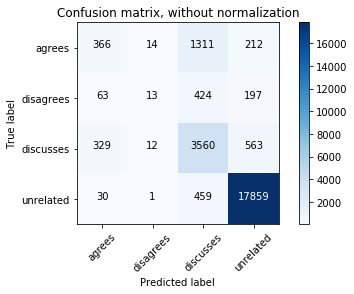

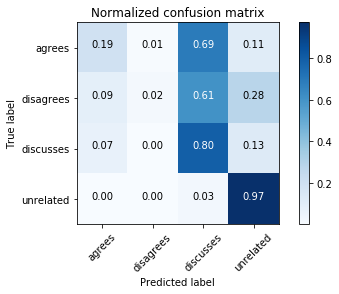

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds_test)
class_names = ["agrees", "disagrees", "discusses", "unrelated"]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

#plt.show()
plt.savefig("baseline-ourfetures-2step-gbt-testset-normalizedconf.png")

In [ ]:
-----

In [ ]:
# Row 4: Baseline + 3 features + 2-step + RF

In [19]:
X_train = pd.read_hdf("X_train_disjoint-allfeatures-2.h5", key="df")
y_train = pd.read_hdf("y_train_disjoint.h5", key="df")
y_train = y_train["Stance"]

X_dev = pd.read_hdf("X_dev_disjoint-allfeatures-2.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")
y_dev = y_dev["Stance"]
del_str_cols(X_dev)

X_test = pd.read_hdf("X_TEST-allfeatures-2.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")
y_test = y_test["Stance"]
del_str_cols(X_test)

def prep_2step_sets(X_train, y_train):
    Xy_train = pd.concat([X_train, y_train], axis=1)

    Xy_train_1 = Xy_train.copy()
    Xy_train_1.loc[Xy_train_1["Stance"] != "unrelated", 'Stance'] = "related"
    y_train_1 = Xy_train_1["Stance"]
    X_train_1 = Xy_train_1.drop(["Stance"], axis=1)

    Xy_train_2 = Xy_train[Xy_train["Stance"] != "unrelated"]
    y_train_2 = Xy_train_2["Stance"]
    X_train_2 = Xy_train_2.drop("Stance", axis=1)

    del_str_cols(X_train_1)
    del_str_cols(X_train_2)
    
    return X_train_1, y_train_1, X_train_2, y_train_2


X_train_1, y_train_1, X_train_2, y_train_2 = prep_2step_sets(X_train, y_train)
print(X_train_1.shape)
print(y_train_1.shape)
print(X_train_2.shape)
print(y_train_2.shape)


## CLASSIFIER 1 - RELATED/UNRELATED
mod1_a = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod1_a.fit(X_train_1, y_train_1)

## CLASSIFIER 2 - 3-class
mod2_a = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod2_a.fit(X_train_2, y_train_2)


preds_dev = predict_tsm(mod1_a, mod2_a, X_dev)
print("DEV results:")
print_reports(preds_dev, y_dev)


X_dev_1, y_dev_1, X_dev_2, y_dev_2 = prep_2step_sets(X_dev, y_dev)
print(X_dev_1.shape)
print(y_dev_1.shape)
print(X_dev_2.shape)
print(y_dev_2.shape)

X_train_1_full = pd.concat([X_train_1, X_dev_1], axis=0)
y_train_1_full = pd.concat([y_train_1, y_dev_1], axis=0)

X_train_2_full = pd.concat([X_train_2, X_dev_2], axis=0)
y_train_2_full = pd.concat([y_train_2, y_dev_2], axis=0)

print(X_train_1_full.shape)
print(y_train_1_full.shape)

print(X_train_2_full.shape)
print(y_train_2_full.shape)


## CLASSIFIER 1 - RELATED/UNRELATED
mod1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod1.fit(X_train_1_full, y_train_1_full)

## CLASSIFIER 2 - 3-class
mod2 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod2.fit(X_train_2_full, y_train_2_full)


print("TEST results (trained on train+dev):")
preds_test = predict_tsm(mod1, mod2, X_test)
print_reports(preds_test, y_test)

(39437, 53)
(39437,)
(10629, 53)
(10629,)
DEV results:
             precision    recall  f1-score   support

      agree       0.60      0.26      0.36       784
   disagree       1.00      0.07      0.13       209
    discuss       0.65      0.85      0.73      1805
  unrelated       0.97      0.98      0.97      7737

avg / total       0.88      0.88      0.87     10535

Weighted accuracy: 0.8090760209202811 (3828.75 out of 4732.25)
(10535, 53)
(10535,)
(2798, 53)
(2798,)
(49972, 53)
(49972,)
(13427, 53)
(13427,)
TEST results (trained on train+dev):
             precision    recall  f1-score   support

      agree       0.46      0.17      0.24      1903
   disagree       0.00      0.00      0.00       697
    discuss       0.62      0.79      0.69      4464
  unrelated       0.94      0.98      0.96     18349

avg / total       0.82      0.86      0.83     25413

Weighted accuracy: 0.7613560776740693 (8870.75 out of 11651.25)


In [20]:
print_feature_importances(mod1, X_train_1_full)

bin_count_stopless: 0.24026175543945338
ngram_2_early_hits: 0.14785768480407271
ngram_2_hits: 0.10765807951086952
word_overlap_features: 0.09845858252892857
bin_count_early: 0.06823276253314316
bin_count: 0.04975811117875905
ngram_3_hits: 0.037532147253880564
hl_body_glove_200_cos_dist: 0.029269720170934984
hl_body_verb_glove_200_cos_dist: 0.0219291116467431
chargram_2_hits: 0.021740801081131952
ngram_3_early_hits: 0.019876432082182458
vader_body_compound: 0.018868443109740677
vader_body_neu: 0.017096475002828914
vader_body_neg: 0.016864481564688213
vader_body_pos: 0.015460178904926587
vader_hl_neu: 0.013475745559104779
vader_hl_compound: 0.01288509992118288
vader_hl_neg: 0.012341066215301379
chargram_2_early_hits: 0.011735829695105306
ngram_4_hits: 0.009334507337278326
chargram_2_first_hits: 0.007729417030661707
vader_hl_pos: 0.00625742928641883
polar_body: 0.0030757386352540956
ngram_4_early_hits: 0.0023756359851706058
ngram_5_hits: 0.0017914996421876336
polar_hl: 0.00168942686020118

In [ ]:
print_feature_importances(mod2, X_train_1_full)

In [ ]:
# Row 5: 800 trees for RFs

In [21]:
X_train = pd.read_hdf("X_train_disjoint-allfeatures-2.h5", key="df")
y_train = pd.read_hdf("y_train_disjoint.h5", key="df")
y_train = y_train["Stance"]

X_dev = pd.read_hdf("X_dev_disjoint-allfeatures-2.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")
y_dev = y_dev["Stance"]
del_str_cols(X_dev)

X_test = pd.read_hdf("X_TEST-allfeatures-2.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")
y_test = y_test["Stance"]
del_str_cols(X_test)

def prep_2step_sets(X_train, y_train):
    Xy_train = pd.concat([X_train, y_train], axis=1)

    Xy_train_1 = Xy_train.copy()
    Xy_train_1.loc[Xy_train_1["Stance"] != "unrelated", 'Stance'] = "related"
    y_train_1 = Xy_train_1["Stance"]
    X_train_1 = Xy_train_1.drop(["Stance"], axis=1)

    Xy_train_2 = Xy_train[Xy_train["Stance"] != "unrelated"]
    y_train_2 = Xy_train_2["Stance"]
    X_train_2 = Xy_train_2.drop("Stance", axis=1)

    del_str_cols(X_train_1)
    del_str_cols(X_train_2)
    
    return X_train_1, y_train_1, X_train_2, y_train_2


X_train_1, y_train_1, X_train_2, y_train_2 = prep_2step_sets(X_train, y_train)
print(X_train_1.shape)
print(y_train_1.shape)
print(X_train_2.shape)
print(y_train_2.shape)


## CLASSIFIER 1 - RELATED/UNRELATED
mod1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=420, min_samples_split=4, min_samples_leaf=2)
mod1.fit(X_train_1, y_train_1)

## CLASSIFIER 2 - 3-class
mod2 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=420, min_samples_split=4, min_samples_leaf=2)
mod2.fit(X_train_2, y_train_2)


preds_dev = predict_tsm(mod1, mod2, X_dev)
print("DEV results:")
print_reports(preds_dev, y_dev)


X_dev_1, y_dev_1, X_dev_2, y_dev_2 = prep_2step_sets(X_dev, y_dev)
print(X_dev_1.shape)
print(y_dev_1.shape)
print(X_dev_2.shape)
print(y_dev_2.shape)

X_train_1_full = pd.concat([X_train_1, X_dev_1], axis=0)
y_train_1_full = pd.concat([y_train_1, y_dev_1], axis=0)

X_train_2_full = pd.concat([X_train_2, X_dev_2], axis=0)
y_train_2_full = pd.concat([y_train_2, y_dev_2], axis=0)

print(X_train_1_full.shape)
print(y_train_1_full.shape)

print(X_train_2_full.shape)
print(y_train_2_full.shape)


## CLASSIFIER 1 - RELATED/UNRELATED
mod1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=420, max_features=None)
mod1.fit(X_train_1_full, y_train_1_full)

## CLASSIFIER 2 - 3-class
mod2 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=420, max_features=None)
mod2.fit(X_train_2_full, y_train_2_full)


print("TEST results (trained on train+dev):")
preds_test = predict_tsm(mod1, mod2, X_test)
print_reports(preds_test, y_test)

(39437, 53)
(39437,)
(10629, 53)
(10629,)
DEV results:
             precision    recall  f1-score   support

      agree       0.58      0.23      0.33       784
   disagree       1.00      0.06      0.12       209
    discuss       0.64      0.84      0.73      1805
  unrelated       0.96      0.97      0.97      7737

avg / total       0.88      0.88      0.86     10535

Weighted accuracy: 0.8034233187173121 (3802.0 out of 4732.25)
(10535, 53)
(10535,)
(2798, 53)
(2798,)
(49972, 53)
(49972,)
(13427, 53)
(13427,)
TEST results (trained on train+dev):
             precision    recall  f1-score   support

      agree       0.38      0.20      0.26      1903
   disagree       0.07      0.00      0.01       697
    discuss       0.61      0.75      0.67      4464
  unrelated       0.94      0.97      0.96     18349

avg / total       0.82      0.85      0.83     25413

Weighted accuracy: 0.7514644351464436 (8755.5 out of 11651.25)


In [22]:
print_feature_importances(mod1, X_train)

Body ID: 0.6927699315889738
___clean_headline: 0.049827386146191144
ngram_3_early_hits: 0.04365710977001009
wrf_hl_bogus: 0.03633118239677147
chargram_8_first_hits: 0.0272770117264156
chargram_4_hits: 0.021074321698327236
vader_hl_neg: 0.013681908789063859
chargram_16_first_hits: 0.012444478155580975
hl_body_glove_200_cos_dist: 0.011917020790033143
hl_body_verb_glove_200_cos_dist: 0.011472442801665855
Headline: 0.010752647688736197
chargram_16_early_hits: 0.009897065980680332
chargram_4_first_hits: 0.009729680749489846
wrf_hl_doubts: 0.008644122035026134
ngram_4_hits: 0.007371795686722213
chargram_4_early_hits: 0.006603097798362504
articleBody: 0.0064497966540942205
chargram_16_hits: 0.005762535288436218
ngram_4_early_hits: 0.004581598442860821
wrf_hl_debunk: 0.001701783953199042
wrf_hl_doubt: 0.0017015501333818544
wrf_hl_hoax: 0.0011465101318106153
word_overlap_features: 0.0007589622812599086
wrf_hl_nope: 0.0007544627255044123
bin_count: 0.0006647910821650179
wrf_hl_retract: 0.0005601

In [23]:
print_feature_importances(mod2, X_train)

vader_hl_neg: 0.09443646873547128
hl_body_verb_glove_200_cos_dist: 0.08854697342946308
chargram_8_first_hits: 0.08309549444885148
hl_body_glove_200_cos_dist: 0.08228722117425027
chargram_16_first_hits: 0.080167113535895
chargram_4_hits: 0.07561643422711849
___clean_headline: 0.07497266686489126
ngram_3_early_hits: 0.04909784466906741
ngram_4_hits: 0.03386360210365696
chargram_16_early_hits: 0.033379430559569954
chargram_4_first_hits: 0.031596233072361916
articleBody: 0.030104765213434904
Body ID: 0.028042589097982056
Headline: 0.02712862551138057
ngram_4_early_hits: 0.02575665413945108
wrf_hl_doubts: 0.022575103815794043
chargram_4_early_hits: 0.022089297812387394
chargram_16_hits: 0.018240785793526944
wrf_hl_bogus: 0.016961798892113817
wrf_hl_doubt: 0.014457891973553825
wrf_hl_nope: 0.014328285905007357
___clean_body_tokenized_lemmas: 0.014119452744575321
wrf_hl_debunk: 0.010353218503744956
wrf_hl_pranks: 0.006908469089941991
wrf_hl_retract: 0.004741213259020177
polar_hl: 0.0032738732

In [24]:
X_train.head()

,Headline,articleBody,Body ID,___clean_headline,___clean_headline_tokenized_lemmas,___clean_body,___clean_body_tokenized_lemmas,bin_count,bin_count_early,bin_count_stopless,...,hl_body_glove_200_cos_dist,hl_body_verb_glove_200_cos_dist,vader_hl_neg,vader_hl_neu,vader_hl_pos,vader_hl_compound,vader_body_neg,vader_body_neu,vader_body_pos,vader_body_compound
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\n\n...,712,police find mass graves with at least 15 bodie...,"[police, find, mass, graf, with, at, least, 15...",danny boyle is directing the untitled film set...,"[danny, boyle, is, directing, the, untitled, f...",2,0,0,...,0.157001,0.221717,0.194,0.806,0.0,-0.4767,0.008,0.907,0.085,0.9409
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,137,christian bale passes on role of steve jobs ac...,"[christian, bale, pass, on, role, of, steve, j...",30 year old moscow resident was hospitalized w...,"[30, year, old, moscow, resident, wa, hospital...",5,4,1,...,0.104475,0.173301,0.000,1.000,0.0,0.0000,0.116,0.805,0.079,-0.7506
5,'Nasa Confirms Earth Will Experience 6 Days of...,Thousands of people have been duped by a fake ...,154,nasa confirms earth will experience 6 days of ...,"[nasa, confirms, earth, will, experience, 6, d...",thousands of people have been duped by a fake ...,"[thousand, of, people, have, been, duped, by, ...",17,15,14,...,0.033813,0.080282,0.267,0.733,0.0,-0.6249,0.157,0.815,0.029,-0.9950
6,Accused Boston Marathon Bomber Severely Injure...,A British fighter who travelled to Iraq to sto...,962,accused boston marathon bomber severely injure...,"[accused, boston, marathon, bomber, severely, ...",a british fighter who travelled to iraq to sto...,"[a, british, fighter, who, travelled, to, iraq...",4,1,1,...,0.104640,0.165519,0.528,0.472,0.0,-0.8807,0.162,0.787,0.052,-0.9991
7,Identity of ISIS terrorist known as 'Jihadi Jo...,"Adding to Apple's iOS 8 launch troubles, a rep...",2033,identity of isis terrorist known as jihadi joh...,"[identity, of, isi, terrorist, known, a, jihad...",adding to apple s ios 8 launch troubles a repo...,"[adding, to, apple, s, io, 8, launch, trouble,...",2,1,0,...,0.243533,0.246454,0.343,0.657,0.0,-0.6908,0.027,0.911,0.062,0.8316


In [ ]:
# Row 6: diff models

In [6]:
X_train = pd.read_hdf("X_train_disjoint-allfeatures-2.h5", key="df")
y_train = pd.read_hdf("y_train_disjoint.h5", key="df")
y_train = y_train["Stance"]

X_dev = pd.read_hdf("X_dev_disjoint-allfeatures-2.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")
y_dev = y_dev["Stance"]
del_str_cols(X_dev)

X_test = pd.read_hdf("X_TEST-allfeatures-2.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")
y_test = y_test["Stance"]
del_str_cols(X_test)

def prep_2step_sets(X_train, y_train):
    Xy_train = pd.concat([X_train, y_train], axis=1)

    Xy_train_1 = Xy_train.copy()
    Xy_train_1.loc[Xy_train_1["Stance"] != "unrelated", 'Stance'] = "related"
    y_train_1 = Xy_train_1["Stance"]
    X_train_1 = Xy_train_1.drop(["Stance"], axis=1)

    Xy_train_2 = Xy_train[Xy_train["Stance"] != "unrelated"]
    y_train_2 = Xy_train_2["Stance"]
    X_train_2 = Xy_train_2.drop("Stance", axis=1)

    del_str_cols(X_train_1)
    del_str_cols(X_train_2)
    
    return X_train_1, y_train_1, X_train_2, y_train_2


X_train_1, y_train_1, X_train_2, y_train_2 = prep_2step_sets(X_train, y_train)
print(X_train_1.shape)
print(y_train_1.shape)
print(X_train_2.shape)
print(y_train_2.shape)


## CLASSIFIER 1 - RELATED/UNRELATED
mod1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=420, min_samples_split=4, min_samples_leaf=2)
mod1.fit(X_train_1, y_train_1)

## CLASSIFIER 2 - 3-class
#mod2 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=420, min_samples_split=4, min_samples_leaf=2)
mod2 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod2.fit(X_train_2, y_train_2)

def predict_tsm(mod1, mod2, X):
        #if X is None:
        #    X = self.X_dev_1
        del_str_cols(X)
        preds_1 = mod1.predict(X)
        preds_2 = mod2.predict(X) # note X_dev_1
        
        new_preds = preds_1.copy()
        for ii in range(preds_1.shape[0]):
            if preds_1[ii] == "related":
                new_preds[ii] = preds_2[ii]
            else:
                new_preds[ii] = "unrelated"
        return new_preds

preds_dev = predict_tsm(mod1, mod2, X_dev)
print("DEV results:")
print_reports(preds_dev, y_dev)


X_dev_1, y_dev_1, X_dev_2, y_dev_2 = prep_2step_sets(X_dev, y_dev)
print(X_dev_1.shape)
print(y_dev_1.shape)
print(X_dev_2.shape)
print(y_dev_2.shape)

X_train_1_full = pd.concat([X_train_1, X_dev_1], axis=0)
y_train_1_full = pd.concat([y_train_1, y_dev_1], axis=0)

X_train_2_full = pd.concat([X_train_2, X_dev_2], axis=0)
y_train_2_full = pd.concat([y_train_2, y_dev_2], axis=0)

print(X_train_1_full.shape)
print(y_train_1_full.shape)

print(X_train_2_full.shape)
print(y_train_2_full.shape)


## CLASSIFIER 1 - RELATED/UNRELATED
mod1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=420, max_features=None)
mod1.fit(X_train_1_full, y_train_1_full)

## CLASSIFIER 2 - 3-class
#mod2 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=420, max_features=None)
mod2 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod2.fit(X_train_2_full, y_train_2_full)


print("TEST results (trained on train+dev):")
preds_test = predict_tsm(mod1, mod2, X_test)
print_reports(preds_test, y_test)

(39437, 53)
(39437,)
(10629, 53)
(10629,)
      Iter       Train Loss   Remaining Time 
         1        9637.6448           12.09s
         2        9343.4160           13.34s
         3        9096.6649           14.07s
         4        8880.6659           13.74s
         5        8694.5556           13.29s
         6        8531.4964           12.53s
         7        8393.5862           11.98s
         8        8270.7897           11.74s
         9        8163.0356           11.40s
        10        8065.7804           11.04s
        20        7499.3412            9.45s
        30        7216.2666            8.57s
        40        7003.1268            7.87s
        50        6824.1222            7.31s
        60        6674.2162            6.69s
        70        6529.9345            6.12s
        80        6404.2150            5.54s
        90        6294.9514            5.03s
       100        6178.0779            4.69s
       200        5317.4053            0.00s
DEV results:

In [ ]:
---------------

In [ ]:
X_train = pd.read_hdf("X_train_disjoint-allfeatures.h5", key="df")
y_train = pd.read_hdf("y_train_disjoint.h5", key="df")

X_dev = pd.read_hdf("X_dev_disjoint-allfeatures.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")

X_test = pd.read_hdf("X_TEST-allfeatures.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")



In [ ]:
%time X_train = add_all_features(X_train)
%time X_dev = add_all_features(X_dev)
%time X_test = add_all_features(X_test)

In [ ]:
X_train.to_hdf('X_train_disjoint-allfeatures-2.h5','df')
X_dev.to_hdf('X_dev_disjoint-allfeatures-2.h5','df')
X_test.to_hdf('X_TEST-allfeatures-2.h5','df')

In [ ]:
---------

In [ ]:
X_train = pd.read_hdf("X_train_disjoint-allfeatures-2.h5", key="df")
y_train = pd.read_hdf("y_train_disjoint.h5", key="df")
y_train = y_train["Stance"]

X_dev = pd.read_hdf("X_dev_disjoint-allfeatures-2.h5", key="df")
y_dev = pd.read_hdf("y_dev_disjoint.h5", key="df")
y_dev = y_dev["Stance"]
del_str_cols(X_dev)

X_test = pd.read_hdf("X_TEST-allfeatures-2.h5", key="df")
y_test = pd.read_hdf("y_TEST_disjoint.h5", key="df")
y_test = y_test["Stance"]
del_str_cols(X_test)


In [ ]:
# Step 1 -- turn into 1/2 sets
def prep_2step_sets(X_train, y_train):
    Xy_train = pd.concat([X_train, y_train], axis=1)

    Xy_train_1 = Xy_train.copy()
    Xy_train_1.loc[Xy_train_1["Stance"] != "unrelated", 'Stance'] = "related"
    y_train_1 = Xy_train_1["Stance"]
    X_train_1 = Xy_train_1.drop(["Stance"], axis=1)

    Xy_train_2 = Xy_train[Xy_train["Stance"] != "unrelated"]
    y_train_2 = Xy_train_2["Stance"]
    X_train_2 = Xy_train_2.drop("Stance", axis=1)

    del_str_cols(X_train_1)
    del_str_cols(X_train_2)
    
    return X_train_1, y_train_1, X_train_2, y_train_2

In [ ]:
X_train_1, y_train_1, X_train_2, y_train_2 = prep_2step_sets(X_train, y_train)

In [ ]:
print(X_train_1.shape)
print(y_train_1.shape)
print(X_train_2.shape)
print(y_train_2.shape)

In [ ]:
## CLASSIFIER 1 - RELATED/UNRELATED
#mod1 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod1 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod1.fit(X_train_1, y_train_1)

## CLASSIFIER 2 - 3-class
#mod2 = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod2 = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)
mod2.fit(X_train_2, y_train_2)

In [ ]:
def predict_tsm(mod1, mod2, X):
        #if X is None:
        #    X = self.X_dev_1
        del_str_cols(X)
        preds_1 = mod1.predict(X)
        preds_2 = mod2.predict(X) # note X_dev_1
        
        new_preds = preds_1.copy()
        for ii in range(preds_1.shape[0]):
            if preds_1[ii] == "related":
                new_preds[ii] = preds_2[ii]
            else:
                new_preds[ii] = "unrelated"
        return new_preds

In [ ]:
preds_rf_test = predict_tsm(mod1, mod2, X_test) # actually GBTs
print_reports(preds_rf_test, y_test)

In [ ]:
preds_rf_test = predict_tsm(mod1, mod2, X_test)
print_reports(preds_rf_test, y_test)

In [ ]:
----

In [ ]:
preds_rf = predict_tsm(mod1, mod2, X_dev)

In [ ]:
# RFs
print_reports(preds_rf, y_dev)

In [ ]:
# GBTs:
print_reports(preds, y_dev)

In [ ]:
#mod_one = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)
mod_one = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=True)

In [ ]:
del_str_cols(X_train)

In [ ]:
mod_one.fit(X_train, y_train)

In [ ]:
# RFs:
preds_one = mod_one.predict(X_dev)
print_reports(preds, y_dev)

In [ ]:
# GBTs:
preds_one = mod_one.predict(X_dev)
print_reports(preds, y_dev)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_dev, preds_rf)
class_names = ["agrees", "disagrees", "discusses", "unrelated"]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
----

In [ ]:
crf = sklearn.ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8, random_state=42)

In [ ]:
crf.fit(X_train, y_train)

In [ ]:
preds = crf.predict(X_dev)
print(classification_report(y_dev, preds))

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, preds, labels=["agree", "disagree", "discuss"], sample_weight=None)